In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from tqdm import tqdm

import collections
from random import choice
import copy

from graph_tool.all import *

threshold: 1, 2, 4, 8

#### Locate folder

In [2]:
#source = '/mnt/lynxkite/data/kite_data/upload/'
source = '/mnt/processed_data/day_graphs_cleaned/'

#### Read all filenames and sort

In [3]:
files = sorted([ i for i in os.listdir(source) if '.csv.gz' in i ])
files = np.array( sorted([ i for i in files if 'output_' in i ]) )
files.shape, files[:3], files[-4:]

((151,),
 array(['output_20181201.csv.gz', 'output_20181202.csv.gz',
        'output_20181203.csv.gz'], dtype='<U22'),
 array(['output_20190507.csv.gz', 'output_20190508.csv.gz',
        'output_20190509.csv.gz', 'output_20190513.csv.gz'], dtype='<U22'))

#### Select the year 2018

In [4]:
# 2018.12.01-2019.11.30

In [5]:
files[:3], files[-3:], files.shape

(array(['output_20181201.csv.gz', 'output_20181202.csv.gz',
        'output_20181203.csv.gz'], dtype='<U22'),
 array(['output_20190508.csv.gz', 'output_20190509.csv.gz',
        'output_20190513.csv.gz'], dtype='<U22'),
 (151,))

In [6]:
df = pd.read_csv( source+files[0], delimiter=',' )
df.head()

,src,dst,traffic
0,215383,221780,53.076923
1,158921,155074,25.933346
2,287324,286044,15.146370
3,300701,299423,15.099999
4,116773,114859,14.469997


In [7]:
df.shape

(45529, 3)

#### Preprocess data to be able to parse it

In [8]:
src_part = df.src.values
dst_part = df.dst.values
weight_part = []
for i in range( df.shape[0] ):
    weight_part.append( '{\'weight\': '+str( np.round( df.traffic[i], 4 ) )[:7]+'}' )
weight_part = np.array( weight_part )
src_part[:3], dst_part[:3], weight_part[:3]

(array([215383, 158921, 287324]),
 array([221780, 155074, 286044]),
 array(["{'weight': 53.0769}", "{'weight': 25.9333}",
        "{'weight': 15.1464}"], dtype='<U19'))

In [9]:
grap_to_parse = []
for i in range( src_part.shape[0] ):
     grap_to_parse.append( str(src_part[i]) + ' ' + str( dst_part[i]) +' ' + weight_part[i] )

In [10]:
grap_to_parse[:5]

["215383 221780 {'weight': 53.0769}",
 "158921 155074 {'weight': 25.9333}",
 "287324 286044 {'weight': 15.1464}",
 "300701 299423 {'weight': 15.1}",
 "116773 114859 {'weight': 14.47}"]

#### Creation of graph

In [11]:
G = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.Graph())

#### Check if graph is correct

In [12]:
[ i for i in nx.all_neighbors( G, 215383) ]

[221780, 209642, 221769, 210257]

In [13]:
G_nodes_id = np.array( [i[0] for i in G.nodes(True) ] ).astype(int)
G_nodes_df = pd.read_csv( source+'boxids_500.csv' ).iloc[ G_nodes_id ]
G_nodes_df_header = list( G_nodes_df )
G_nodes_id = G_nodes_df.values

#### Automatization of this process

In [14]:
def create_day_graph_from_csv( path_to_file ):
    df = pd.read_csv( path_to_file, delimiter=',' )
    src_part = df.src.values
    dst_part = df.dst.values
    weight_part = []
    
    for i in range( df.shape[0] ):
        weight_part.append( '{\'weight\': '+str( np.round( df.traffic[i], 4 ) )[:7]+'}' )
    weight_part = np.array( weight_part )
    
    grap_to_parse = []
    for i in range( src_part.shape[0] ):
         grap_to_parse.append( str(src_part[i]) + ' ' + str( dst_part[i]) +' ' + weight_part[i] )
            
    G = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.Graph())
    # graph node id based on cell id
    G_nodes_id = np.array( [i[0] for i in G.nodes(True) ] ).astype(int)
    G_nodes_df = pd.read_csv( source+'boxids_500.csv' ).iloc[ G_nodes_id ]
    G_nodes_df_header = list( G_nodes_df )
    G_nodes_id = G_nodes_df.values
    
    return G, G_nodes_id, G_nodes_df_header

In [15]:
def degree_centrality( g ):
    return nx.algorithms.degree_centrality( g )

In [16]:
def closeness_centrality( g ):
    return nx.algorithms.centrality.closeness_centrality( g )

In [17]:
def betweenness_centrality( g ):
    return nx.algorithms.centrality.betweenness_centrality( g )

In [18]:
def average_neighbor_degree( g ):
    return nx.algorithms.average_neighbor_degree( g )

In [19]:
def pagerank( g ):
    return nx.pagerank( g )

In [20]:
def clustering( g ):
    return nx.algorithms.cluster.clustering( g )

In [21]:
def susceptibility_chi( conn_comps, size ):
    return np.sum( np.sort( conn_comps )[:-1]**2 ) / size**2 # np.sum( np.square(conn_comps) ) # leaving out the largest conn. comp.

In [22]:
def degree_distribution( g, uplim=100, title='Degree distribution' ):
    degree_sequence = sorted( [ d for n, d in g.degree() ], reverse=True)  

    degreeCount = collections.Counter( degree_sequence )
    degree, count = zip( *degreeCount.items() )

    plt.figure( num=1, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k' )
    plt.bar(degree, count, color='g')
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    #plt.xlim([0,uplim])
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

In [23]:
G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( source+files[0] )

In [24]:
len(G.nodes), len(G.edges)

(7744, 25886)

In [25]:
G_nodes_id[:2]

array([[2.15383000e+05, 6.41940000e+04, 5.95091000e+05, 4.59201982e+01,
        1.83397559e+01],
       [2.21780000e+05, 6.76940000e+04, 6.00091000e+05, 4.59520705e+01,
        1.84038254e+01]])

In [26]:
G_nodes_df_header

['boxid', 'eovx', 'eovy', 'lat', 'lon']

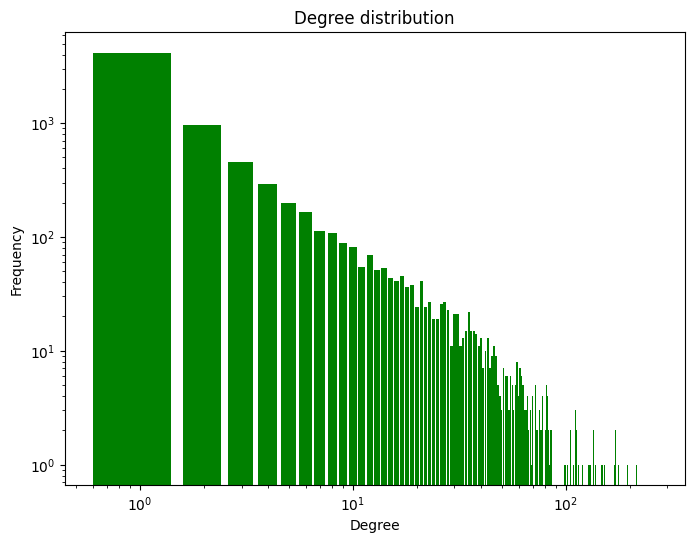

In [27]:
degree_distribution( G )

#### Convert nx graph to Graph-tool graph to get some processing speed increase

https://bbengfort.github.io/snippets/2016/06/23/graph-tool-from-networkx.html (outdated)

https://gist.github.com/tomshaffner/7a2df7f9ec6b1be33dd0413897125683 (updated, works with nx 2.5)

In [28]:
def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, str):
        # Encode the key as utf-8
        key = key.encode('utf-8', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        value = value.encode('utf-8', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)
        
    #If key is a byte value, decode it to string
    try:
        key = key.decode('utf-8')
    except AttributeError:
        pass

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in list(nxG.graph.items()):
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)
            
            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in list(data.items()):
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in list(data.items()):
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG

#### Metrics to be calculated:

In [29]:
def calculate_betweenness(g):
    vertex, edge = betweenness(g)
    return list(vertex)#, list(edge)

In [30]:
def calculate_closeness(g):
    vertex = closeness(g)
    return list(vertex)

In [31]:
def calculate_pagerank(g):
    vertex = pagerank(g)
    return list(vertex)

In [32]:
def calculate_eigenvector(g):
    largest_num, vertex = eigenvector(g)
    return list(vertex)

In [33]:
def calculate_katz(g):
    vertex = katz(g)
    return list(vertex)

In [34]:
def calculate_local_clustering(g):
    vertex = local_clustering(g)
    return list(vertex)

In [35]:
def calculate_motifs(g):
    mots, counts = motifs( g, k=3 )
    return mots, counts

#### New calculations, tests

In [36]:
#read graph from csv file
day_csv = pd.read_csv( source+files[0] )
G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( path_to_file=source+files[0] )
# convert to Graph-tool graph object
gtG = nx2gt(G)

In [37]:
assortativity(gtG, 'total' )

(-0.002059810557708779, 0.0007746856726677772)

In [38]:
scalar_assortativity(gtG, 'total' )

(0.13500607677779186, 0.007620110253051484)

In [39]:
pseudo_diameter(gtG)

(44.0,
 (<Vertex object with index '1241' at 0x7f3882dd09f0>,
  <Vertex object with index '7390' at 0x7f3882dd0a50>))

In [40]:
sum(1 for c in max_cliques(gtG))

15741

In [69]:
list(max_cliques(gtG))

[array([   0,    1, 2563], dtype=uint64),
 array([   0,    1, 2001], dtype=uint64),
 array([   0, 1350], dtype=uint64),
 array([2, 3], dtype=uint64),
 array([   3, 6148,  725], dtype=uint64),
 array([   3, 3145], dtype=uint64),
 array([2274,    3,  333], dtype=uint64),
 array([   3, 1667,  333, 1267,  725], dtype=uint64),
 array([   3, 2726,  333, 1266, 1267], dtype=uint64),
 array([   3, 3240,  333, 1266, 1267], dtype=uint64),
 array([   3,  333, 1266, 1267, 1815], dtype=uint64),
 array([   3, 3240,  333, 1267,  725], dtype=uint64),
 array([  3, 333, 725, 438], dtype=uint64),
 array([   3,  333, 1266, 2716], dtype=uint64),
 array([   3, 5647], dtype=uint64),
 array([   3, 6928], dtype=uint64),
 array([  3, 725, 726], dtype=uint64),
 array([   3, 6425], dtype=uint64),
 array([   3, 3866], dtype=uint64),
 array([   3, 3933], dtype=uint64),
 array([   3, 4327,  725], dtype=uint64),
 array([   3, 1983], dtype=uint64),
 array([   4, 3948], dtype=uint64),
 array([4515,    4, 2164], dtype=ui

In [70]:
len( list(min_spanning_tree(gtG)) )

25886

In [72]:
sum(list(min_spanning_tree(gtG)))

7639

In [61]:
topological_sort(gtG) # not working, because graph is not DAG!

ValueError: Graph is not a directed acylic graph (DAG).

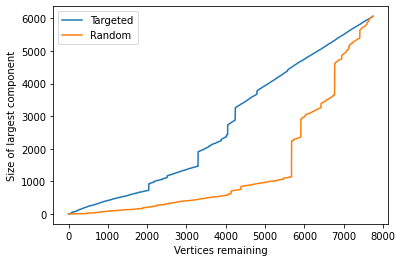

In [42]:
vertices = sorted([v for v in gtG.vertices()], key=lambda v: v.in_degree())
sizes, comp = vertex_percolation(gtG, vertices)
np.random.shuffle(vertices)
sizes2, comp = vertex_percolation(gtG, vertices)
plt.figure()
plt.plot(sizes, label="Targeted")
plt.plot(sizes2, label="Random")
plt.xlabel("Vertices remaining")
plt.ylabel("Size of largest component")
plt.legend(loc="upper left")
#savefig("vertex-percolation.svg")

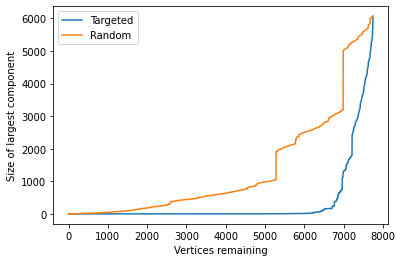

In [43]:
vertices = sorted([v for v in gtG.vertices()], key=lambda v: v.out_degree())
sizes, comp = vertex_percolation(gtG, vertices)
np.random.shuffle(vertices)
sizes2, comp = vertex_percolation(gtG, vertices)
plt.figure()
plt.plot(sizes, label="Targeted")
plt.plot(sizes2, label="Random")
plt.xlabel("Vertices remaining")
plt.ylabel("Size of largest component")
plt.legend(loc="upper left")
#savefig("vertex-percolation.svg")

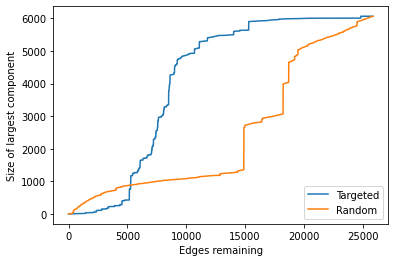

In [44]:
edges = sorted([(e.source(), e.target()) for e in gtG.edges()],
               key=lambda e: e[0].out_degree() * e[1].out_degree())
sizes, comp = edge_percolation(gtG, edges)
np.random.shuffle(edges)
sizes2, comp = edge_percolation(gtG, edges)
plt.figure()
plt.plot(sizes, label="Targeted")
plt.plot(sizes2, label="Random")
plt.xlabel("Edges remaining")
plt.ylabel("Size of largest component")
plt.legend(loc="lower right")

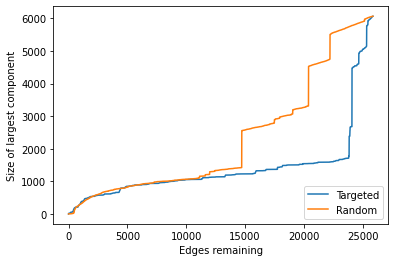

In [45]:
edges = sorted([(e.source(), e.target()) for e in gtG.edges()],
               key=lambda e: e[0].out_degree() * e[1].in_degree())
sizes, comp = edge_percolation(gtG, edges)
np.random.shuffle(edges)
sizes2, comp = edge_percolation(gtG, edges)
plt.figure()
plt.plot(sizes, label="Targeted")
plt.plot(sizes2, label="Random")
plt.xlabel("Edges remaining")
plt.ylabel("Size of largest component")
plt.legend(loc="lower right")

In [52]:
g = copy.deepcopy(gtG)
g = GraphView(g, vfilt=label_largest_component(g))
kcore = kcore_decomposition(g)
graph_draw(g, vertex_fill_color=kcore, vertex_text=kcore, output="netsci-kcore.svg")

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f3846a393c8, at 0x7f38b9d74a20>

In [53]:
edge_reciprocity(gtG)

1.0

In [55]:
global_clustering(gtG, ret_counts=True)

((0.34951758067772476, 0.01642639391914133), 131571, 1129308)

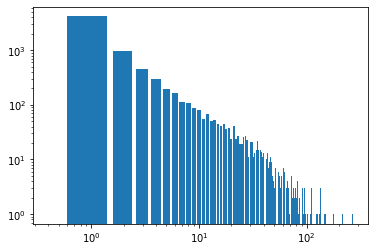

In [60]:
counts, bins = vertex_hist(gtG, 'total')
plt.bar( bins[:-1], counts )
plt.xscale('log')
plt.yscale('log')

In [61]:
vertex_average(gtG, 'total')

(6.68543388429752, 0.18098193044176103)

<BarContainer object of 45 artists>

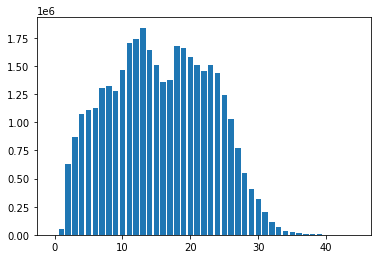

In [73]:
counts, bins = distance_histogram( gtG )
plt.bar( bins[:-1], counts )

In [75]:
counts[:10]

array([      0.,   51833.,  630150.,  869963., 1075634., 1110007.,
       1122756., 1300000., 1322323., 1273667.])

In [66]:
n_paths = count_shortest_paths(gtG, 92, 45)
print(n_paths)

16


#### Select output folder

In [36]:
destination = '/mnt/graph_analitics_data/'

In [54]:
for f in tqdm( range( files.shape[0] ) ):
    #print(f)
    # box_id (csúcs), földrajzi koordináták, metrikák
    savename = destination+'graph_vertex_attr_'+files[f].split('.')[0][-8:]+'.csv'
    if not os.path.exists( savename ):

        #read graph from csv file
        day_csv = pd.read_csv( source+files[f] )
        G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( path_to_file=source+files[f] )
        # convert to Graph-tool graph object
        gtG = nx2gt(G)

        vertex_attrs = []
        vertex_attrs.append( calculate_betweenness(gtG) )
        vertex_attrs.append( calculate_closeness(gtG) )
        #vertex_attrs.append( calculate_pagerank(gtG) )
        vertex_attrs.append( calculate_eigenvector(gtG) )
        #vertex_attrs.append( calculate_katz(gtG) )
        vertex_attrs.append( calculate_local_clustering(gtG) )

        vertex_attrs = np.array(vertex_attrs).T
        vertex_attrs = np.concatenate( (G_nodes_id, vertex_attrs), axis=1 )
        vertex_df = pd.DataFrame( vertex_attrs, 
                                  columns=(G_nodes_df_header+[ 'betweenness', 'closeness', 'eigenvector', "local_clustering"]) )
        vertex_df.to_csv( savename, index=None )
        #print(vertex_attrs.shape)
    else:
        print('Already processed, skipping!') 

 50%|█████     | 67/133 [05:21<05:16,  4.80s/it]


KeyboardInterrupt: 

### Updated

In [1]:
# Created by A. Biricz 01.12.2020.

# Load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from tqdm import tqdm
import json

import collections
from random import choice
import copy

from graph_tool.all import *

# Locate data
source = '/mnt/DayGraphData/'
destination = '/mnt/DayGraphAnalytics/'

files = sorted([ i for i in os.listdir(source) if '.csv.gz' in i ])
files = np.array( sorted([ i for i in files if 'output_' in i ]) )
files.shape, files[:3], files[-4:]

# Function definitions

def create_day_graph_from_csv( path_to_file ):
    df = pd.read_csv( path_to_file, delimiter=',' )
    src_part = df.src.values
    dst_part = df.dst.values
    weight_part = []
    for i in range( df.shape[0] ):
        weight_part.append( '{\'weight\': '+str( int( df.weight.values[i] ) )[:7]+'}' )
    weight_part = np.array( weight_part )
    
    grap_to_parse = []
    for i in range( src_part.shape[0] ):
         grap_to_parse.append( str( int(src_part[i]) ) + ' ' + str( int(dst_part[i]) ) +' ' + weight_part[i] )
    
    G = nx.parse_edgelist( grap_to_parse , delimiter=' ', nodetype=int, create_using=nx.Graph())
    # graph node locations
    G_nodes_id = np.array( [i[0] for i in G.nodes(True) ] ).astype(int)
    nodes_coords = np.zeros( (G_nodes_id.shape[0], 3) )
    src_dst_coords = np.unique( np.concatenate( ( df.iloc[:,[0,3,4]], 
                                                  df.iloc[:,[1,5,6]] ) ),axis=0 )
    for i in range(G_nodes_id.shape[0]):
        loc_in_src_idx = np.argwhere(G_nodes_id[i]==src_dst_coords[:,0])
        nodes_coords[i] = src_dst_coords[loc_in_src_idx[0,0]]
    
    G_nodes_df_header = ["node_id", "eovx", "eovy"]
    
    return G, nodes_coords, G_nodes_df_header
    

def get_prop_type(value, key=None):
    """
    Performs typing and value conversion for the graph_tool PropertyMap class.
    If a key is provided, it also ensures the key is in a format that can be
    used with the PropertyMap. Returns a tuple, (type name, value, key)
    """
    if isinstance(key, str):
        # Encode the key as utf-8
        key = key.encode('utf-8', errors='replace')

    # Deal with the value
    if isinstance(value, bool):
        tname = 'bool'

    elif isinstance(value, int):
        tname = 'float'
        value = float(value)

    elif isinstance(value, float):
        tname = 'float'

    elif isinstance(value, str):
        tname = 'string'
        value = value.encode('utf-8', errors='replace')

    elif isinstance(value, dict):
        tname = 'object'

    else:
        tname = 'string'
        value = str(value)
        
    #If key is a byte value, decode it to string
    try:
        key = key.decode('utf-8')
    except AttributeError:
        pass

    return tname, value, key


def nx2gt(nxG):
    """
    Converts a networkx graph to a graph-tool graph.
    """
    # Phase 0: Create a directed or undirected graph-tool Graph
    gtG = Graph(directed=nxG.is_directed())

    # Add the Graph properties as "internal properties"
    for key, value in list(nxG.graph.items()):
        # Convert the value and key into a type for graph-tool
        tname, value, key = get_prop_type(value, key)

        prop = gtG.new_graph_property(tname) # Create the PropertyMap
        
        gtG.graph_properties[key] = prop     # Set the PropertyMap
        gtG.graph_properties[key] = value    # Set the actual value

    # Phase 1: Add the vertex and edge property maps
    # Go through all nodes and edges and add seen properties
    # Add the node properties first
    nprops = set() # cache keys to only add properties once
    for node, data in nxG.nodes(data=True):

        # Go through all the properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in nprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key  = get_prop_type(val, key)

            prop = gtG.new_vertex_property(tname) # Create the PropertyMap
            gtG.vertex_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            nprops.add(key)

    # Also add the node id: in NetworkX a node can be any hashable type, but
    # in graph-tool node are defined as indices. So we capture any strings
    # in a special PropertyMap called 'id' -- modify as needed!
    gtG.vertex_properties['id'] = gtG.new_vertex_property('string')

    # Add the edge properties second
    eprops = set() # cache keys to only add properties once
    for src, dst, data in nxG.edges(data=True):

        # Go through all the edge properties if not seen and add them.
        for key, val in list(data.items()):            
            if key in eprops: continue # Skip properties already added

            # Convert the value and key into a type for graph-tool
            tname, _, key = get_prop_type(val, key)
            
            prop = gtG.new_edge_property(tname) # Create the PropertyMap
            gtG.edge_properties[key] = prop     # Set the PropertyMap

            # Add the key to the already seen properties
            eprops.add(key)

    # Phase 2: Actually add all the nodes and vertices with their properties
    # Add the nodes
    vertices = {} # vertex mapping for tracking edges later
    for node, data in nxG.nodes(data=True):

        # Create the vertex and annotate for our edges later
        v = gtG.add_vertex()
        vertices[node] = v

        # Set the vertex properties, not forgetting the id property
        data['id'] = str(node)
        for key, value in list(data.items()):
            gtG.vp[key][v] = value # vp is short for vertex_properties

    # Add the edges
    for src, dst, data in nxG.edges(data=True):

        # Look up the vertex structs from our vertices mapping and add edge.
        e = gtG.add_edge(vertices[src], vertices[dst])

        # Add the edge properties
        for key, value in list(data.items()):
            gtG.ep[key][e] = value # ep is short for edge_properties

    # Done, finally!
    return gtG


def calculate_betweenness(g):
    vertex, edge = betweenness(g)
    return list(vertex)#, list(edge)


def calculate_closeness(g):
    vertex = closeness(g)
    return list(vertex)
    
    
def calculate_pagerank(g):
    vertex = pagerank(g)
    return list(vertex)


def calculate_eigenvector(g):
    largest_num, vertex = eigenvector(g)
    return list(vertex)


def calculate_katz(g):
    vertex = katz(g)
    return list(vertex)
    
    
def calculate_local_clustering(g):
    vertex = local_clustering(g)
    return list(vertex)
    
      
def calculate_motifs(g):
    mots, counts = motifs( g, k=3 )
    return mots, counts


for f in tqdm( range( args.start_idx, args.end_idx ) ):
    # node_id, földrajzi koordináták, metrikák
    savename = destination+'graph_vertex_attributes_'+files[f].split('.')[0][-8:]+'.csv'
    if not os.path.exists( savename ):

        #read graph from csv file
        day_csv = pd.read_csv( source+files[f] )
        G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( path_to_file=source+files[f] )
        # convert to Graph-tool graph object
        gtG = nx2gt(G)

        vertex_attrs = []
        vertex_attrs.append( calculate_betweenness(gtG) )
        vertex_attrs.append( calculate_closeness(gtG) )
        #vertex_attrs.append( calculate_pagerank(gtG) )
        vertex_attrs.append( calculate_eigenvector(gtG) )
        #vertex_attrs.append( calculate_katz(gtG) )
        vertex_attrs.append( calculate_local_clustering(gtG) )

        vertex_attrs = np.array(vertex_attrs).T
        vertex_attrs = np.concatenate( (G_nodes_id, vertex_attrs), axis=1 )
        vertex_df = pd.DataFrame( vertex_attrs, 
                                  columns=(G_nodes_df_header+[ 'betweenness', 'closeness', 'eigenvector', "local_clustering"]) )
        vertex_df.to_csv( savename, index=None )
        #print(vertex_attrs.shape)
    else:
        print('Already processed, skipping!') 

In [ ]:
#read graph from csv file
day_csv = pd.read_csv( source+files[0] )
G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( path_to_file=source+files[0] )
# convert to Graph-tool graph object
#gtG = nx2gt(G)

In [3]:
G_nodes_id.shape, G_nodes_df_header, G_nodes_id

((35953, 3),
 ['node_id', 'eovx', 'eovy'],
 array([[0.00000000e+00, 2.50856824e+05, 5.57281563e+05],
        [1.00000000e+00, 2.43355613e+05, 5.58407330e+05],
        [2.00000000e+00, 2.47247015e+05, 5.49713112e+05],
        ...,
        [4.24880000e+04, 1.73890400e+05, 6.96379689e+05],
        [1.57970000e+04, 2.46036413e+05, 6.68367587e+05],
        [4.20910000e+04, 1.72722000e+05, 5.61798406e+05]]))

In [4]:
# convert to Graph-tool graph object
gtG = nx2gt(G)
gtG

<Graph object, undirected, with 35953 vertices and 3330138 edges, 1 internal vertex property, 1 internal edge property, at 0x7f7f60531278>

In [6]:
vertex_attrs = []

In [7]:
%%time
vertex_attrs.append( calculate_betweenness(gtG) )

CPU times: user 1h 59min 27s, sys: 13.8 s, total: 1h 59min 41s
Wall time: 8min 20s


In [8]:
%%time
vertex_attrs.append( calculate_closeness(gtG) )

CPU times: user 1h 8min 3s, sys: 2.26 s, total: 1h 8min 5s
Wall time: 4min 39s


In [9]:
%%time
vertex_attrs.append( calculate_eigenvector(gtG) )

CPU times: user 6.21 s, sys: 64 ms, total: 6.27 s
Wall time: 490 ms


In [10]:
%%time
vertex_attrs.append( calculate_local_clustering(gtG) )

CPU times: user 13.4 s, sys: 44 ms, total: 13.5 s
Wall time: 1.95 s


In [11]:
vertex_attrs = np.array(vertex_attrs).T

In [12]:
vertex_attrs.shape

(35953, 4)

In [13]:
vertex_attrs = np.concatenate( (G_nodes_id, vertex_attrs), axis=1 )
vertex_df = pd.DataFrame( vertex_attrs, 
                          columns=(G_nodes_df_header+[ 'betweenness', 'closeness', 'eigenvector', "local_clustering"]) )

In [14]:
vertex_df.head()

,node_id,eovx,eovy,betweenness,closeness,eigenvector,local_clustering
0,0.0,250856.823812,557281.563448,0.000212,0.381867,0.001787,0.257070
1,1.0,243355.613091,558407.330182,0.000021,0.346158,0.000433,0.326804
2,2.0,247247.015480,549713.111971,0.000133,0.366835,0.001217,0.298291
3,3.0,248652.682532,551070.875000,0.000006,0.338209,0.000238,0.372684
4,228.0,210082.546182,529989.300280,0.000159,0.347346,0.000229,0.201867


In [ ]:
for f in tqdm( range( 1)):#files.shape[0] ) ):
    #print(f)
    # box_id (csúcs), földrajzi koordináták, metrikák
    savename = destination+'graph_vertex_attributes_'+files[f].split('.')[0][-8:]+'.csv'
    if not os.path.exists( savename ):

        #read graph from csv file
        day_csv = pd.read_csv( source+files[f] )
        G, G_nodes_id, G_nodes_df_header = create_day_graph_from_csv( path_to_file=source+files[f] )
        # convert to Graph-tool graph object
        gtG = nx2gt(G)

        vertex_attrs = []
        vertex_attrs.append( calculate_betweenness(gtG) )
        vertex_attrs.append( calculate_closeness(gtG) )
        #vertex_attrs.append( calculate_pagerank(gtG) )
        vertex_attrs.append( calculate_eigenvector(gtG) )
        #vertex_attrs.append( calculate_katz(gtG) )
        vertex_attrs.append( calculate_local_clustering(gtG) )

        vertex_attrs = np.array(vertex_attrs).T
        vertex_attrs = np.concatenate( (G_nodes_id, vertex_attrs), axis=1 )
        vertex_df = pd.DataFrame( vertex_attrs, 
                                  columns=(G_nodes_df_header+[ 'betweenness', 'closeness', 'eigenvector', "local_clustering"]) )
        ####vertex_df.to_csv( savename, index=None )
        #print(vertex_attrs.shape)
    else:
        print('Already processed, skipping!') 